In [1]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)

In [2]:
print('here')

here


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# !pip install pyspark

In [7]:
# pip install grpc-status

  Using cached grpc-status-1.0.0.tar.gz (5.2 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\prakash.pandey\AppData\Local\Temp\pip-install-f0fk93ep\grpc-status_8a5bcf5b7dd04058939a67e6a450aaa3\setup.py", line 33, in <module>
          raise RuntimeError(HINT)
      RuntimeError: Please install the official package with: pip install grpcio-status
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [23]:
import pandas as pd
import numpy as np
from model_workflow import train_model
import joblib


In [25]:
# pip install databricks

In [27]:
# pip install databricks-connect

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\prakash.pandey\\Miniconda3\\envs\\mle-dev\\Lib\\site-packages\\~rpc\\_cython\\cygrpc.cp310-win_amd64.pyd'
Consider using the `--user` option or check the permissions.




     ---------------------------------------- 2.1/2.1 MB 3.4 MB/s eta 0:00:00
     -------------------------------------- 301.7/301.7 kB 6.2 MB/s eta 0:00:00
     -------------------------------------- 230.9/230.9 kB 7.1 MB/s eta 0:00:00
     ---------------------------------------- 3.7/3.7 MB 4.1 MB/s eta 0:00:00
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.59.0
    Uninstalling grpcio-1.59.0:
      Successfully uninstalled grpcio-1.59.0


In [30]:
# from databricks.connect import DatabricksSession

# session = DatabricksSession.builder.getOrCreate()

In [1]:
# from pyspark.sql.session import SparkSession

# spark = SparkSession.builder.getOrCreate()

ModuleNotFoundError: No module named 'grpc_status'

In [20]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("temps-demo").getOrCreate()
# spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

ModuleNotFoundError: No module named 'grpc_status'

In [14]:
import json
with open("./config.json") as file:
    config_data = json.load(file)

basin_of_interest = "ANADARKO EAST"
reservoirs_of_interest = tuple(config_data[basin_of_interest]["reservoirs_of_interest"])

In [15]:
basins_of_interest = list(config_data.keys())
for basin_of_interest in ["ANADARKO EAST"]:
  reservoirs_of_interest = config_data[basin_of_interest]["reservoirs_of_interest"]

  model_performance, model_pipeline,operator_list, meta_data, model_params, training_model = train_model(
  basin_of_interest=basin_of_interest,
  reservoirs=reservoirs_of_interest,
  config_param=config_data,
  spark=spark
)
  joblib.dump(model_pipeline, f"pipeline_cost_ft_{basin_of_interest.lower()}.pickle")

  with open(f"error_results_cost_ft{basin_of_interest.lower()}.json", "w") as outfile:
      json.dump(model_performance["error_results"], outfile)
  print(f"{basin_of_interest} Done")

NameError: name 'train_model' is not defined

In [9]:
with open(f"operator_list_cost_ft_{basin_of_interest.lower()}.json", "w") as outfile:
    json.dump(operator_list, outfile)
print(f"{basin_of_interest} Done")

ANADARKO EAST Done


In [10]:
model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['Proppant_LBSPerFT',
                                                   'Fluid_BBLPerFT',
                                                   'LateralLength_FT',
                                                   'LatitudeMP',
                                                   'LongitudeMP']),
                                                 ('cat_reservoir',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False,
                                                                                 sparse_output=False))]),
                                                  ['ReservoirGoldConsolidated']),
                                                 ('cat_operator',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False,
                                                                                 sparse_output=False))]),
                                                  ['OperatorGold'])])),
                ('model', HuberRegressor(max_iter=1000))])

# Anadarko Validation

In [11]:
import pandas as pd
import numpy as np
import json
import joblib
import geopandas as gpd
from model_training import transformations, inverse_transformations

In [12]:
def model_predict(
  input_data: pd.DataFrame,
  pipeline: callable,
  error_results: dict = None,
  transformation_config: dict = None,
  drilling_cost_multiplier: float = 0.325,
  completions_cost_multiplier: float = 0.625,
  facilities_cost_multiplier: float = 0.05,

):
  input_data_copy = input_data.copy(deep=True)
  try:
    total_cost = pipeline.predict(input_data)
  except:
    txt = "miscellaneous"
    input_data['OperatorGold'] = input_data['OperatorGold'].str.split('_').str[0]+'_'+txt
    total_cost = pipeline.predict(input_data)

  input_data_copy = inverse_transformations(input_data_copy, transformation_config)

  results = {
    "TotalCost_USDMM": np.round(total_cost * input_data_copy["LateralLength_FT"]/(10**6), 2),
    "CostPerFt_USD/FT": np.round(total_cost, 2),
    "Drilling_USDMM": np.round(total_cost * drilling_cost_multiplier, 2),
    "Facilities_USDMM": np.round(total_cost * facilities_cost_multiplier, 2),
    "Completions_USDMM": np.round(total_cost * completions_cost_multiplier, 2),
  }

  if error_results:
    bins_ll = error_results.get("error_bins_lateral_length")
    bin_name_ll = [f"{int(bins_ll[i-1])} - {int(bins_ll[i])}" for i in range(1, len(bins_ll))]

    bins_prop = error_results.get("error_bins_proppant")
    bin_name_prop = [f"{int(bins_prop[i-1])} - {int(bins_prop[i])}" for i in range(1, len(bins_prop))]

    bins_fluid = error_results.get("error_bins_fluid")
    bin_name_fluid= [f"{int(bins_fluid[i-1])} - {int(bins_fluid[i])}" for i in range(1, len(bins_fluid))]

    input_data_copy["bins_ll"] = pd.cut(input_data_copy["LateralLength_FT"], bins_ll, labels=bin_name_ll)
    input_data_copy["bins_prop"] = pd.cut(input_data_copy["Proppant_LBSPerFT"], bins_prop, labels=bin_name_prop)
    input_data_copy["bins_fluid"] = pd.cut(input_data_copy["Fluid_BBLPerFT"], bins_fluid, labels=bin_name_fluid)

    error_list = []
    for _, row in input_data_copy.iterrows():
      prop = error_results.get("error_dict").get(row["bins_ll"], None)
      if prop is None:
        error_list.append(np.nan)
        continue

      fluid = prop.get(row["bins_prop"], None)
      if fluid is None:
        error_list.append(np.nan)
        continue

      error = fluid.get(row["bins_fluid"], np.nan)

      error_list.append(error)


  results["expected_cost_variance"] = error_list

  return results

In [13]:
def get_lat_long(filename, filepath):
  twnshps_of_interest_gpd = gpd.read_file(f'{filepath}/{filename}')

  lat = []
  long = []

  for index, row in twnshps_of_interest_gpd.iterrows():


    coords = gpd.GeoSeries(row["geometry"]).centroid
    la, lo = (coords.x , coords.y)
    lat.append(la.values[0])
    long.append(lo.values[0])

  twnshps_of_interest_gpd["latitude"] = long
  twnshps_of_interest_gpd["longitude"] = lat

  if "MIDLAND" in filename:
      twnshps_of_interest_gpd = twnshps_of_interest_gpd[twnshps_of_interest_gpd["Basin"] == "Midland"].rename(columns={"Name": "NAME"})
      twnshps_of_interest_gpd["NAME"] = twnshps_of_interest_gpd["NAME"].astype(int)
  elif "DELAWARE" in filename:
      twnshps_of_interest_gpd = twnshps_of_interest_gpd[twnshps_of_interest_gpd["Basin"] == "Delaware"].rename(columns={"Name": "NAME"})
      twnshps_of_interest_gpd["NAME"] = twnshps_of_interest_gpd["NAME"].astype(int)

  return twnshps_of_interest_gpd

In [17]:
reservoir_map = {'WDFD': "WOODFORD", 'MISS': "MISSISSIPPIAN"}

# Tests


In [15]:
import pandas as pd
import numpy as np
import json
import joblib
import geopandas as gpd
from model_training import transformations, inverse_transformations
from data_downloader import Downloader
from shapely.geometry import LineString

In [19]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("temps-demo").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

In [16]:
with open("./config_cost_ft.json") as file:
    config_data = json.load(file)
basin_of_interest = "ANADARKO EAST"
reservoirs = config_data.get(basin_of_interest).get("reservoirs_of_interest")

In [17]:
df = Downloader(
  basin_of_interest=basin_of_interest.upper(),
  reservoirs_of_interest=tuple([reservoir.upper() for reservoir in reservoirs]),
  dataset_completions="produced.vw_well_completions_merged",
  dataset_enverus="produced.premerge_enverus_completions",
  impute_from_enverus=True
).run(spark)

In [18]:

df["LatitudeMP"] = df.apply(
    lambda x: np.nanmean([x["LatitudeBHWGS84"], x["LatitudeSHWGS84"]]), axis=1
)
df["LongitudeMP"] = df.apply(
    lambda x: np.nanmean([x["LongitudeBHWGS84"], x["LongitudeSHWGS84"]]), axis=1
)

In [19]:
pd.set_option("display.max_columns", 50)
display(df)

,API10,API14,WellName,LatitudeBHWGS84,LatitudeSHWGS84,LongitudeBHWGS84,LongitudeSHWGS84,CompletionDate,CompletionCost_USDMM,DrillCost_USDMM,FacilitiesCost_USDMM,TotalWellCost_USDMM,Proppant_LBSPerFT,Fluid_BBLPerFT,TVD_FT,LateralLength_FT,OperatorGold,ReservoirGoldConsolidated,cost_filter,LatitudeMP,LongitudeMP
0,3501725427,35017254270000,WM WALLACE 1406 6H-18X,35.696343,35.668365,-97.873151,-97.875313,2019-10-15 19:00:00,3.822971,1.987945,0.305838,6.116754,2023.280979,45.242295,8621.54,10136.0,OVV,MISSISSIPPIAN,False,35.682354,-97.874232
1,3507325219,35073252190000,MIKE 1H-17X,35.956423,35.926929,-98.069047,-98.068642,2016-03-05 18:00:00,3.455570,1.796897,0.276446,5.528913,1566.523992,19.963368,8508.51,10170.0,OVV,MISSISSIPPIAN,False,35.941676,-98.068844
2,3507326446,35073264460000,HENNESSEY UNIT 1907 2LOH-33,36.073375,36.087292,-97.947934,-97.947205,2019-05-08 19:00:00,2.891405,1.503531,0.231312,4.626249,1763.228456,38.031417,7734.33,4955.0,CANVAS,MISSISSIPPIAN,False,36.080333,-97.947569
3,3508722335,35087223350000,DOG-STELLA 0604 30-19-2WXH,34.986825,34.967361,-97.668431,-97.662791,2022-06-29 19:00:00,5.156160,2.681203,0.412493,8.249856,1956.691208,62.522775,11700.00,7552.0,89ENERGY,WOODFORD,False,34.977093,-97.665611
4,3508722375,35087223750000,MOOSE 0604 29-20 5WXH,34.985679,34.959705,-97.638553,-97.643022,2022-11-30 18:00:00,6.492346,3.376020,0.519388,10.387754,2491.005913,60.603527,11277.00,9471.0,89ENERGY,WOODFORD,False,34.972692,-97.640787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5716,3507325575,35073255750000,ENGLE 18-05-35 1H,35.999743,35.986271,-97.701720,-97.701648,2017-08-04 19:00:00,2.302903,1.197509,0.184232,3.684644,832.251016,49.420785,6975.00,4673.0,CHISHOLM O&G,MISSISSIPPIAN,False,35.993007,-97.701684
5717,3501725846,35017258460000,BAKER 1107 3SMH-4,35.450464,35.465266,-97.939010,-97.942749,2023-01-19 18:00:00,4.202103,2.185094,0.336168,6.723365,3207.286057,65.570806,10121.00,4590.0,CANVAS,WOODFORD,False,35.457865,-97.940879
5718,3504323576,35043235760000,BETH 32-20-17 1H,36.172690,36.158096,-99.043262,-99.042915,2018-02-23 18:00:00,2.732571,1.420937,0.218606,4.372113,771.668505,31.215074,11094.57,4896.0,DIVERSIFIED,MISSISSIPPIAN,False,36.165393,-99.043089
5719,3501725035,35017250350000,LYDIA 3-16H,35.434830,35.421417,-97.837266,-97.835932,2018-04-29 19:00:00,3.182202,1.654745,0.254576,5.091523,1218.067973,26.580331,9175.93,9901.0,COTERRA,MISSISSIPPIAN,False,35.428124,-97.836599


In [20]:

def extract_gpd_model(df: pd.DataFrame, cols: list = None, crs: str = 'EPSG:4326'):
    """
    Function to extract gopandas model from lat long mentioned in the df
    """

    line_geometry = []
    if not cols:
        cols = ['API14', 'LatitudeSHWGS84', 'LongitudeSHWGS84', 'LatitudeBHWGS84', 'LongitudeBHWGS84']

    if not set(cols).issubset(df.columns):
        print("Required columns not available")

    gpd_wells_df = df[cols].drop_duplicates()

    # create a dataframe with surface and bottom hole location data along with production and spud date.
    for api in gpd_wells_df['API14'].unique():
        tmp_df = df[df['API14'] == api]

        # extract the coordinates
        geo_coord_tmp = [
            [tmp_df['LongitudeSHWGS84'].values[0], tmp_df['LatitudeSHWGS84'].values[0]],
            [tmp_df['LongitudeBHWGS84'].values[0], tmp_df['LatitudeBHWGS84'].values[0]]
        ]
        line_geometry.append(LineString(geo_coord_tmp))

    return gpd.GeoDataFrame(gpd_wells_df, geometry=line_geometry, crs=crs)


In [22]:
a_east_basin_wells_gpd = extract_gpd_model(df)


In [23]:

basin_of_interest = "ANADARKO EAST"
reservoirs_of_interest = config_data[basin_of_interest]["reservoirs_of_interest"]
transformation_config = config_data[basin_of_interest]["transformations"]
inputs = config_data[basin_of_interest]["input_features"]

if config_data[basin_of_interest]["encode"]:
    inputs.append(config_data[basin_of_interest]["categorical_feature"])

loaded_model = joblib.load(f"pipeline_cost_ft_{basin_of_interest.lower()}.pickle")

with open(f"error_results_{basin_of_interest.lower()}.json") as file:
    error_dict = json.load(file)

filename = f"{basin_of_interest}.shp"
filepath = f"C:/Users/jsingh/Documents/local_projects/PC_projects/capex/shapely/shapely/{basin_of_interest}"

twnshps_of_interest_gpd = gpd.read_file(f'{filepath}/{filename}')


In [24]:

# basin_of_interest = 'ANADARKO EAST'
# filename = f"{basin_of_interest}.shp"
# filepath = f"C:/Users/jsingh/Documents/local_projects/PC_projects/capex/shapely/shapely/{basin_of_interest}"

# twnshps_of_interest_gpd = get_lat_long(filename, filepath)

twnshps_wells = gpd.sjoin(
    twnshps_of_interest_gpd[['Area', 'geometry']],
    a_east_basin_wells_gpd[['API14', 'geometry']],
    how='inner',
    op='intersects'
)

# Count the no of wellls in each TWNSHPLAB and show in the descending order
twnshps_wells[['Area', 'API14']].groupby('Area').count().sort_values('API14', ascending=False).head(20)


,API14
Area,
Core STACK - Volatile Oil,782
Fringe STACK - Oil,551
Core STACK - LYGC,523
Core STACK - HYGC,337
South STACK - Low Yield,295
NW STACK - Low Yield,256
North SCOOP - Deep Oil,244
South STACK - High Yield,237
Core SCOOP - Shallow LYWG,219


In [25]:
twnshps_of_interest_gpd.head(5)

,Shape__Are,Shape__Len,Basin,Reservoir,Area,AreaType,QEP_UID,FlowUnit_A,FlowUnit_I,geometry
0,2.881532e+09,316444.424229,Anadarko,Mississippian,NW STACK - Gas,TCA,TypeCurveArea_TCA_NW STACK Gas_1,Mississippian,"Woodford, Mississippian","POLYGON ((-98.94832 35.70457, -98.95913 35.812..."
1,1.754208e+10,619989.055677,Anadarko,Mississippian,NW STACK - Low Yield,TCA,TypeCurveArea_TCA_NW STACK Low Yield_2,Mississippian,"Woodford, Mississippian","POLYGON ((-99.12159 36.05650, -99.12174 36.158..."
2,6.508530e+09,513117.160665,Anadarko,Mississippian,NW STACK - High Yield,TCA,TypeCurveArea_TCA_NW STACK High Yield_3,Mississippian,"Woodford, Mississippian","POLYGON ((-98.88611 36.15906, -98.40765 36.159..."
3,7.087723e+09,458083.298817,Anadarko,Mississippian,NW STACK - Oil,TCA,TypeCurveArea_TCA_NW STACK Oil_4,Mississippian,"Woodford, Mississippian","POLYGON ((-98.40765 36.15921, -98.03375 36.160..."
4,1.087032e+10,520176.358362,Anadarko,Mississippian,Core STACK - Gas,TCA,TypeCurveArea_TCA_STACK Gas_5,Mississippian,"Woodford, Mississippian","POLYGON ((-98.94806 35.70197, -98.94279 35.700..."


In [37]:
all_wells_df = df.merge(twnshps_wells[["Area", "API14"]], on="API14")
#all_wells_df = all_wells_df[all_wells_df["ReservoirGoldConsolidated"] == "WOODFORD"]

In [38]:
loaded_model = joblib.load(f"pipeline_cost_ft_anadarko east.pickle")

In [39]:
# loaded_model = joblib.load(f"pipeline_{basin_of_interest.lower()}.pickle")

# with open(f"error_results_{basin_of_interest.lower()}.json") as file:
#     error_dict = json.load(file)


In [40]:

with open(f"error_results_anadarko east.json") as file:
    error_dict = json.load(file)


In [41]:
all_wells_df.columns

Index(['API10', 'API14', 'WellName', 'LatitudeBHWGS84', 'LatitudeSHWGS84',
       'LongitudeBHWGS84', 'LongitudeSHWGS84', 'CompletionDate',
       'CompletionCost_USDMM', 'DrillCost_USDMM', 'FacilitiesCost_USDMM',
       'TotalWellCost_USDMM', 'Proppant_LBSPerFT', 'Fluid_BBLPerFT', 'TVD_FT',
       'LateralLength_FT', 'OperatorGold', 'ReservoirGoldConsolidated',
       'cost_filter', 'LatitudeMP', 'LongitudeMP', 'Area'],
      dtype='object')

In [42]:
with open(f"operator_list_cost_ft_anadarko east.json") as file:
    operator_list = json.load(file)

all_wells_df['OperatorGold'] = all_wells_df['OperatorGold'].apply(lambda x: x if x in operator_list else 'miscellaneous')

In [43]:
all_wells_df['OperatorGold'] = all_wells_df['ReservoirGoldConsolidated']+'_'+all_wells_df['OperatorGold']

In [44]:
all_wells_df.head(5)

,API10,API14,WellName,LatitudeBHWGS84,LatitudeSHWGS84,LongitudeBHWGS84,LongitudeSHWGS84,CompletionDate,CompletionCost_USDMM,DrillCost_USDMM,FacilitiesCost_USDMM,TotalWellCost_USDMM,Proppant_LBSPerFT,Fluid_BBLPerFT,TVD_FT,LateralLength_FT,OperatorGold,ReservoirGoldConsolidated,cost_filter,LatitudeMP,LongitudeMP,Area
0,3501725427,35017254270000,WM WALLACE 1406 6H-18X,35.696343,35.668365,-97.873151,-97.875313,2019-10-15 19:00:00,3.822971,1.987945,0.305838,6.116754,2023.280979,45.242295,8621.54,10136.0,MISSISSIPPIAN_OVV,MISSISSIPPIAN,False,35.682354,-97.874232,South STACK - High Yield
1,3507325219,35073252190000,MIKE 1H-17X,35.956423,35.926929,-98.069047,-98.068642,2016-03-05 18:00:00,3.455570,1.796897,0.276446,5.528913,1566.523992,19.963368,8508.51,10170.0,MISSISSIPPIAN_OVV,MISSISSIPPIAN,False,35.941676,-98.068844,Fringe STACK - Volatile Oil
2,3507325219,35073252190000,MIKE 1H-17X,35.956423,35.926929,-98.069047,-98.068642,2016-03-05 18:00:00,3.455570,1.796897,0.276446,5.528913,1566.523992,19.963368,8508.51,10170.0,MISSISSIPPIAN_OVV,MISSISSIPPIAN,False,35.941676,-98.068844,Core STACK - Volatile Oil
3,3507326446,35073264460000,HENNESSEY UNIT 1907 2LOH-33,36.073375,36.087292,-97.947934,-97.947205,2019-05-08 19:00:00,2.891405,1.503531,0.231312,4.626249,1763.228456,38.031417,7734.33,4955.0,MISSISSIPPIAN_CANVAS,MISSISSIPPIAN,False,36.080333,-97.947569,NW STACK - Oil
4,3507326446,35073264460000,HENNESSEY UNIT 1907 2LOH-33,36.073375,36.087292,-97.947934,-97.947205,2019-05-08 19:00:00,2.891405,1.503531,0.231312,4.626249,1763.228456,38.031417,7734.33,4955.0,MISSISSIPPIAN_CANVAS,MISSISSIPPIAN,False,36.080333,-97.947569,Fringe STACK - Oil


In [46]:
def model_execute_linear(all_wells_df, model, config_data, basin_of_interest, transformation_config, error_dict):

    loaded_model = model
    test_matrix = {
    "API10":[],
    "Type Curve Area":[],
    'Proppant_LBSPerFT': [],
    'Fluid_BBLPerFT': [],
    'LatitudeMP': [],
    'LongitudeMP': [],
    "LateralLength_FT": [],
    #"TVD_FT": [],
    "OperatorGold":[],
    "TotalCost_USDMM": [],
    "Cost_USDPerFT": [],
    "expected_cost_variance_%": [],
    "Actualcost_USDMM":[],
    "ActualcostPerFT":[]}

    if config_data[basin_of_interest]["encode"]:
        test_matrix["OperatorGold"] = []
        test_matrix["ReservoirGoldConsolidated"] = []

    test_dict = all_wells_df.dropna().to_dict(orient="list")

    for i in range(len(test_dict["Area"])):
    #for i in [4]:
        #operator_list = model_performance["operator_list"]

        test_matrix["API10"].append(test_dict["API10"][i])
        test_matrix["Type Curve Area"].append(test_dict["Area"][i])
        test_matrix["Proppant_LBSPerFT"].append(test_dict["Proppant_LBSPerFT"][i])
        test_matrix["Fluid_BBLPerFT"].append(test_dict["Fluid_BBLPerFT"][i])
        test_matrix["LateralLength_FT"].append(test_dict["LateralLength_FT"][i])

        test_matrix["LatitudeMP"].append(test_dict["LatitudeMP"][i])
        test_matrix["LongitudeMP"].append(test_dict["LongitudeMP"][i])
        test_matrix["ReservoirGoldConsolidated"].append(test_dict["ReservoirGoldConsolidated"][i])
        #test_matrix["TVD_FT"].append(test_dict["TVD_FT"][i])
        test_matrix["OperatorGold"].append(test_dict["OperatorGold"][i])
        catvar = test_dict["ReservoirGoldConsolidated"][i]
        operator = test_dict["OperatorGold"][i]
        if not isinstance(catvar, list):
            df_t = pd.DataFrame({
                'Proppant_LBSPerFT': [test_dict["Proppant_LBSPerFT"][i]],
                'Fluid_BBLPerFT': [test_dict["Fluid_BBLPerFT"][i]],
                "LateralLength_FT": [test_dict["LateralLength_FT"][i]],
                #"TVD_FT": [test_dict["TVD_FT"][i]],
                'LatitudeMP': [test_dict["LatitudeMP"][i]],
                'LongitudeMP': [test_dict["LongitudeMP"][i]],
                "ReservoirGoldConsolidated": [catvar],
                "OperatorGold": [operator]
            })
            if transformation_config:
                df_t  = transformations(df_t, transformation_config=transformation_config, order=list(transformation_config.keys()))

            cost_predictions = model_predict(
                input_data=df_t[loaded_model.feature_names_in_],
                pipeline=loaded_model,
                error_results=error_dict,
                transformation_config=transformation_config
            )
            test_matrix["TotalCost_USDMM"].append(cost_predictions.get("TotalCost_USDMM")[0])
            test_matrix["Cost_USDPerFT"].append(cost_predictions.get("CostPerFt_USD/FT")[0])
            test_matrix["expected_cost_variance_%"].append(cost_predictions.get("expected_cost_variance")[0])
            test_matrix["Actualcost_USDMM"].append(test_dict["TotalWellCost_USDMM"][i])
            test_matrix["ActualcostPerFT"].append(10 ** 6 * test_matrix["Actualcost_USDMM"][i] / test_matrix["LateralLength_FT"][i])

    final_df = pd.DataFrame(test_matrix)
    return final_df

    # final_df.to_csv(f"{basin_of_interest}_results.csv")

    # final_df[final_df["LateralLength_FT"] == 5000].to_csv(f"{basin_of_interest}_5000.csv")
    # final_df[final_df["LateralLength_FT"] == 7500].to_csv(f"{basin_of_interest}_7500.csv")
    # final_df[final_df["LateralLength_FT"] == 10000].to_csv(f"{basin_of_interest}_10000.csv")
    # final_df[final_df["LateralLength_FT"] == 12500].to_csv(f"{basin_of_interest}_12500.csv")
    # final_df[final_df["LateralLength_FT"] == 15000].to_csv(f"{basin_of_interest}_15000.csv")

In [47]:
final_df = model_execute_linear(all_wells_df, loaded_model, config_data, basin_of_interest, transformation_config, error_dict)

In [53]:
final_df.head()

,API10,Type Curve Area,Proppant_LBSPerFT,Fluid_BBLPerFT,LatitudeMP,LongitudeMP,LateralLength_FT,OperatorGold,TotalCost_USDMM,Cost_USDPerFT,expected_cost_variance_%,Actualcost_USDMM,ActualcostPerFT,ReservoirGoldConsolidated
0,3501725427,South STACK - High Yield,2023.280979,45.242295,35.682354,-97.874232,10136.0,MISSISSIPPIAN_OVV,6.27,618.13,4.41,6.116754,603.468190,MISSISSIPPIAN
1,3507325219,Fringe STACK - Volatile Oil,1566.523992,19.963368,35.941676,-98.068844,10170.0,MISSISSIPPIAN_OVV,4.90,481.64,NaN,5.528913,543.649231,MISSISSIPPIAN
2,3507325219,Core STACK - Volatile Oil,1566.523992,19.963368,35.941676,-98.068844,10170.0,MISSISSIPPIAN_OVV,4.90,481.64,NaN,5.528913,543.649231,MISSISSIPPIAN
3,3507326446,NW STACK - Oil,1763.228456,38.031417,36.080333,-97.947569,4955.0,MISSISSIPPIAN_CANVAS,3.36,677.25,8.52,4.626249,933.652590,MISSISSIPPIAN
4,3507326446,Fringe STACK - Oil,1763.228456,38.031417,36.080333,-97.947569,4955.0,MISSISSIPPIAN_CANVAS,3.36,677.25,8.52,4.626249,933.652590,MISSISSIPPIAN


In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
final_df["OperatorGold"] = final_df["OperatorGold"].str.split("_").str[-1]
final_df = final_df[final_df["ActualcostPerFT"] < 3000]

In [55]:
import sklearn.metrics as metrics
r2=metrics.r2_score(final_df["Cost_USDPerFT"], final_df["ActualcostPerFT"])
mse=metrics.mean_squared_error(final_df["Cost_USDPerFT"], final_df["ActualcostPerFT"])
rmse=np.sqrt(mse)
mape=(np.abs(final_df["Cost_USDPerFT"]-final_df["ActualcostPerFT"])*100/(final_df["ActualcostPerFT"])).mean()

print(r2, mse, rmse, mape)

0.835184070734364 9723.882030908864 98.60974612536462 5.774332439270456


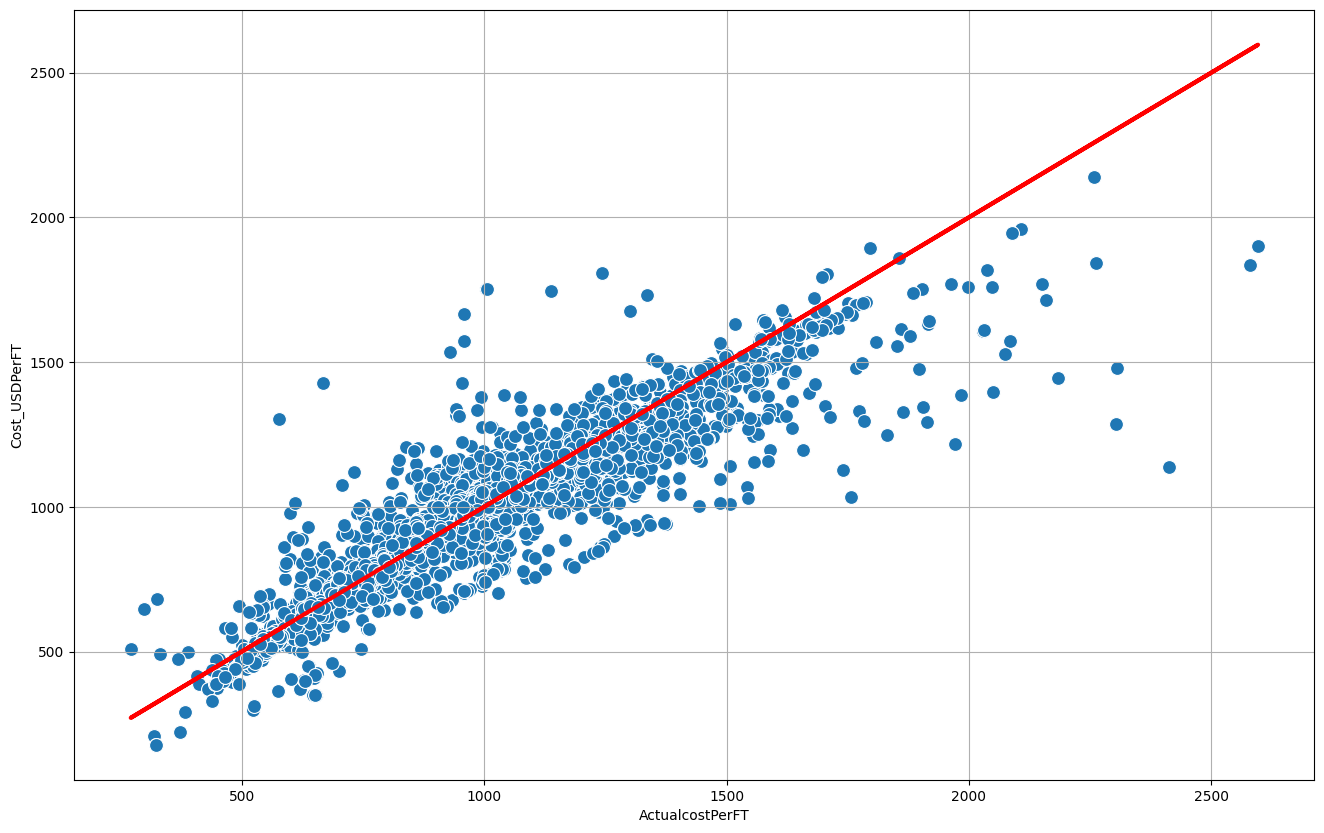

In [52]:
fig, ax = plt.subplots(figsize=(16, 10))
#sns.scatterplot(data=final_df[(final_df.Cost_USDPerFT > 0) & (final_df.ActualcostPerFT < 5000)], x ="ActualcostPerFT", y ="Cost_USDPerFT", hue="expected_cost_variance_%", s=100)
sns.scatterplot(data=final_df, x ="ActualcostPerFT", y ="Cost_USDPerFT", s=100)

plt.plot(final_df[(final_df.Cost_USDPerFT > 0) & (final_df.ActualcostPerFT < 5000)]["ActualcostPerFT"].values, final_df[(final_df.Cost_USDPerFT > 0) & (final_df.ActualcostPerFT < 5000)]["ActualcostPerFT"].values, color='red', linewidth=3)
#plt.xlim([100, 2500])
#plt.ylim([100, 2500])
plt.grid()

# create equation form

In [57]:
coefficients = model_pipeline["model"].coef_
intercept = model_pipeline["model"].intercept_

In [59]:
features= model_pipeline["preprocessor"].transformers_[0][2]+\
    model_pipeline["preprocessor"].transformers_[1][1].get_feature_names_out().tolist()+\
    model_pipeline["preprocessor"].transformers_[2][1].get_feature_names_out().tolist()

In [60]:
# Create the equation string

equation = f'y = {round(intercept, 6)}'
for i, coef in enumerate(coefficients):
    f_string = features[i]
    # if f_string == "LateralLegnth_FT":
    #     f_string = "LateralLegnth_FT"
    # elif  f_string == "Proppant_LBSPerFT":
    #     f_string = "log_LateralLegnth_FT * Proppant_LBSPerFT"
    # elif  f_string == "Fluid_BBLPerFT":
    #     f_string = "log_LateralLegnth_FT * Fluid_BBLPerFT"
    if coef < 0:
        coef = coef * -1
        equation += f' - {round(coef, 6)} * {f_string}'
    else:
        equation += f' + {round(coef, 6)} * {f_string}'

centers = [round(float(i), 5) for i in model_pipeline[0].transformers_[0][1]["scaler"].center_]
scale = [round(float(i), 5) for i in model_pipeline[0].transformers_[0][1]["scaler"].scale_]

In [61]:
equation

'y = 995.741391 + 141.595031 * Proppant_LBSPerFT + 43.856874 * Fluid_BBLPerFT - 206.65536 * LateralLength_FT - 113.481218 * LatitudeMP - 83.225221 * LongitudeMP + 54.997631 * ReservoirGoldConsolidated_WOODFORD - 101.126506 * OperatorGold_MISSISSIPPIAN_BCE-MACH - 216.025448 * OperatorGold_MISSISSIPPIAN_CAMINO - 273.021527 * OperatorGold_MISSISSIPPIAN_CANVAS - 71.151743 * OperatorGold_MISSISSIPPIAN_CHISHOLM O&G - 98.724772 * OperatorGold_MISSISSIPPIAN_CITIZEN + 131.396259 * OperatorGold_MISSISSIPPIAN_CLR - 120.509385 * OperatorGold_MISSISSIPPIAN_COMANCHE - 81.664462 * OperatorGold_MISSISSIPPIAN_COTERRA - 18.860971 * OperatorGold_MISSISSIPPIAN_DEVON - 137.721832 * OperatorGold_MISSISSIPPIAN_DIVERSIFIED + 28.613508 * OperatorGold_MISSISSIPPIAN_EOG - 77.809479 * OperatorGold_MISSISSIPPIAN_EXXON + 247.233654 * OperatorGold_MISSISSIPPIAN_GPOR - 68.280711 * OperatorGold_MISSISSIPPIAN_MARATHON - 220.080387 * OperatorGold_MISSISSIPPIAN_OVV - 192.310501 * OperatorGold_MISSISSIPPIAN_PALOMA - 121.9

In [155]:
df_use = pd.concat([df, pd.get_dummies(df['ReservoirGoldConsolidated'], prefix='ReservoirGoldConsolidated'), pd.get_dummies(df['OperatorGold'], prefix='OperatorGold')], axis=1)
#df_use["log_lat"] = np.log(df_use["LateralLength_FT"])
#df_use["prop_transformed"] = df_use["log_lat"] * df_use["Proppant_LBSPerFT"]
#df_use["fluid_transformed"] = df_use["log_lat"] * df_use["Fluid_BBLPerFT"]

df_use["scaled_prop"] = (df_use["Proppant_LBSPerFT"] - model_pipeline[0].transformers_[0][1]["scaler"].center_[0]) / model_pipeline[0].transformers_[0][1]["scaler"].scale_[0]
df_use["scaled_fluid"] = (df_use["Fluid_BBLPerFT"] - model_pipeline[0].transformers_[0][1]["scaler"].center_[1]) / model_pipeline[0].transformers_[0][1]["scaler"].scale_[1]
df_use["scaled_lat"] = (df_use["LateralLength_FT"] - model_pipeline[0].transformers_[0][1]["scaler"].center_[2]) / model_pipeline[0].transformers_[0][1]["scaler"].scale_[2]
df_use["scaled_latitude"] = (df_use["LatitudeMP"] - model_pipeline[0].transformers_[0][1]["scaler"].center_[3]) / model_pipeline[0].transformers_[0][1]["scaler"].scale_[3]
df_use["scaled_longitude"] = (df_use["LongitudeMP"] - model_pipeline[0].transformers_[0][1]["scaler"].center_[4]) / model_pipeline[0].transformers_[0][1]["scaler"].scale_[4]

# df_use["cost"] = 8.104985 + 0.818809 * df_use["scaled_prop"] + 0.459955 * df_use["scaled_fluid"] + 3.290475 * df_use["scaled_lat"] \
#     - 0.16368 * df_use["scaled_latitude"] + 0.016547 * df_use["scaled_longitude"] \
#         + 3.9362 * df_use["ReservoirGoldConsolidated_BOSSIER"] + 4.168728 * df_use["ReservoirGoldConsolidated_HAYNESVILLE"] \
#             - 1.110165 * df_use["OperatorGold_AETHON"] + 2.020715 * df_use["OperatorGold_BPX"] + 1.444907 * df_use["OperatorGold_CHK"] \
#                 + 0.985575 * df_use["OperatorGold_COMSTOCK"] + 0.685065 * df_use["OperatorGold_EXCO"] + 0.506403 * df_use["OperatorGold_EXXON"]\
#                       - 0.449857 * df_use["OperatorGold_ROCKCLIFF"] + 4.091415 * df_use["OperatorGold_SWN"] - 0.069131 * df_use["OperatorGold_miscellaneous"]

In [156]:
df_use.columns

Index(['API10', 'API14', 'WellName', 'LatitudeBHWGS84', 'LatitudeSHWGS84',
       'LongitudeBHWGS84', 'LongitudeSHWGS84', 'CompletionDate',
       'CompletionCost_USDMM', 'DrillCost_USDMM', 'FacilitiesCost_USDMM',
       'TotalWellCost_USDMM', 'Proppant_LBSPerFT', 'Fluid_BBLPerFT', 'TVD_FT',
       'LateralLength_FT', 'OperatorGold', 'ReservoirGoldConsolidated',
       'cost_filter', 'LatitudeMP', 'LongitudeMP',
       'ReservoirGoldConsolidated_MISSISSIPPIAN',
       'ReservoirGoldConsolidated_WOODFORD', 'OperatorGold_89ENERGY',
       'OperatorGold_BCE-MACH', 'OperatorGold_CAMINO', 'OperatorGold_CANVAS',
       'OperatorGold_CHISHOLM O&G', 'OperatorGold_CITIZEN', 'OperatorGold_CLR',
       'OperatorGold_COMANCHE', 'OperatorGold_COTERRA', 'OperatorGold_DEVON',
       'OperatorGold_DIVERSIFIED', 'OperatorGold_EOG', 'OperatorGold_EXXON',
       'OperatorGold_GPOR', 'OperatorGold_MARATHON', 'OperatorGold_OVV',
       'OperatorGold_PALOMA', 'OperatorGold_miscellaneous', 'scaled_prop',
   

In [157]:
equation

'y = 608.731055 + 143.632386 * Proppant_LBSPerFT + 44.93885 * Fluid_BBLPerFT - 187.821093 * LateralLength_FT - 94.176736 * LatitudeMP - 70.553846 * LongitudeMP + 285.837012 * ReservoirGoldConsolidated_MISSISSIPPIAN + 322.196196 * ReservoirGoldConsolidated_WOODFORD + 107.432451 * OperatorGold_89ENERGY - 8.089176 * OperatorGold_BCE-MACH - 131.985242 * OperatorGold_CAMINO - 167.959785 * OperatorGold_CANVAS + 18.341268 * OperatorGold_CHISHOLM O&G + 17.955231 * OperatorGold_CITIZEN + 196.790143 * OperatorGold_CLR - 17.376074 * OperatorGold_COMANCHE + 45.846696 * OperatorGold_COTERRA + 32.620513 * OperatorGold_DEVON - 33.134941 * OperatorGold_DIVERSIFIED + 108.262338 * OperatorGold_EOG + 68.282692 * OperatorGold_EXXON + 534.915344 * OperatorGold_GPOR + 57.967307 * OperatorGold_MARATHON - 149.415274 * OperatorGold_OVV - 83.207414 * OperatorGold_PALOMA + 10.787131 * OperatorGold_miscellaneous'

In [158]:
df_use["cost"] = intercept+coefficients[0]*df_use["scaled_prop"]+coefficients[1]*df_use["scaled_fluid"]+coefficients[2]*df_use["scaled_lat"] \
    +coefficients[3]*df_use["scaled_latitude"]+coefficients[4]*df_use["scaled_longitude"] \
        +coefficients[5]*df_use["ReservoirGoldConsolidated_MISSISSIPPIAN"]+coefficients[6]*df_use["ReservoirGoldConsolidated_WOODFORD"] \
            +coefficients[7]*df_use["OperatorGold_89ENERGY"]+coefficients[8]*df_use["OperatorGold_BCE-MACH"]+coefficients[9]*df_use["OperatorGold_CAMINO"] \
            +coefficients[10]*df_use["OperatorGold_CANVAS"]+coefficients[11]*df_use["OperatorGold_CHISHOLM O&G"]+coefficients[12]*df_use["OperatorGold_CITIZEN"]+ coefficients[13]*df_use["OperatorGold_CLR"]\
                +coefficients[14]*df_use["OperatorGold_COMANCHE"]+coefficients[15]*df_use["OperatorGold_COTERRA"]+coefficients[16]*df_use["OperatorGold_DEVON"]\
                        +coefficients[17]*df_use["OperatorGold_DIVERSIFIED"]+coefficients[18]*df_use["OperatorGold_EOG"]+coefficients[19]*df_use["OperatorGold_EXXON"]\
                            +coefficients[20]*df_use["OperatorGold_GPOR"]+coefficients[21]*df_use["OperatorGold_MARATHON"]+coefficients[22]*df_use["OperatorGold_OVV"]\
                                +coefficients[23]*df_use["OperatorGold_PALOMA"]+coefficients[24]*df_use["OperatorGold_miscellaneous"]

In [48]:
final_df.describe()

,Proppant_LBSPerFT,Fluid_BBLPerFT,LatitudeMP,LongitudeMP,LateralLength_FT,TVD_FT,TotalCost_USDMM,Cost_USDPerFT,expected_cost_variance_%,Actualcost_USDMM,ActualcostPerFT
count,5934.000000,5934.000000,5934.000000,5934.000000,5934.000000,5934.000000,5934.000000,5934.000000,5061.000000,5934.000000,5934.000000
mean,1977.815382,49.013227,35.488738,-97.985396,7454.310433,10762.241716,6.849621,943.008129,5.948524,6.956404,965.822842
std,744.720317,16.172950,0.483708,0.342119,2584.159935,2488.578601,2.566702,229.057887,4.627172,2.587931,289.455510
min,0.918843,0.013480,33.744685,-99.099817,337.000000,6130.950000,0.550000,115.080000,0.110000,2.241916,272.104460
25%,1473.644840,39.866969,35.113219,-98.185831,4850.250000,8958.410000,4.820000,798.777500,3.680000,4.870706,786.144430
50%,2014.348766,47.993903,35.667416,-97.909733,7563.500000,10374.000000,6.290000,941.225000,4.490000,6.506694,949.137222
75%,2475.183499,58.028401,35.855284,-97.754756,9954.000000,12341.317500,8.740000,1088.540000,6.490000,8.755360,1106.858481
max,9403.783045,201.980889,36.172975,-96.745260,17762.000000,23319.000000,18.190000,2598.680000,39.110000,18.361055,9579.165283


In [46]:
import sklearn.metrics as metrics
r2=metrics.r2_score(final_df["Cost_USDPerFT"], final_df["ActualcostPerFT"])
mse=metrics.mean_squared_error(final_df["Cost_USDPerFT"], final_df["ActualcostPerFT"])
rmse=np.sqrt(mse)
mape=(np.abs(final_df["Cost_USDPerFT"]-final_df["ActualcostPerFT"])*100/(final_df["ActualcostPerFT"])).mean()

print(r2, mse, rmse, mape)


0.5080834380110458 25805.290537221725 160.6402519209358 7.062509908868548
